## Setup and Import Data

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats =['retina']

# Dependencies and Setup
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
sns.set()
plt.rc('lines', linewidth=1)
rcParams['figure.figsize'] = 12,6

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

# Combine the data into a single dataset
mice_data = pd.merge(mouse_metadata, study_results, how='left', on='Mouse ID')
mice_data.set_index('Mouse ID', inplace=True)

# Set the data display options in a float format
pd.options.display.float_format = '{:,.2f}'.format

# Display the data table for preview
mice_data.head()

,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
Mouse ID,,,,,,,
k403,Ramicane,Male,21,16,0,45.00,0
k403,Ramicane,Male,21,16,5,38.83,0
k403,Ramicane,Male,21,16,10,35.01,1
k403,Ramicane,Male,21,16,15,34.22,1
k403,Ramicane,Male,21,16,20,33.00,1


## Cleaning Data

In [2]:
# Checking the dataset size
mice_data.shape

(1893, 7)

In [3]:
# Checking the types of data
mice_data.dtypes

Drug Regimen           object
Sex                    object
Age_months              int64
Weight (g)              int64
Timepoint               int64
Tumor Volume (mm3)    float64
Metastatic Sites        int64
dtype: object

In [4]:
# Checking missing values
mice_data.isnull().sum()

Drug Regimen          0
Sex                   0
Age_months            0
Weight (g)            0
Timepoint             0
Tumor Volume (mm3)    0
Metastatic Sites      0
dtype: int64

In [5]:
# Checking the number of mice.
mice_data.index.value_counts(normalize=True)

g989   0.01
k483   0.01
x401   0.01
s710   0.01
w914   0.01
       ... 
x336   0.00
d133   0.00
t573   0.00
o848   0.00
f932   0.00
Name: Mouse ID, Length: 249, dtype: float64

In [6]:
# Getting the duplicate mice by ID number that shows up for Mouse ID and Timepoint. 
duplicate_mice = [mice_data.groupby([mice_data.index, 'Timepoint']).count()>1][0]
duplicate_mice[duplicate_mice['Drug Regimen']==True]

Drug Regimen   Sex  Age_months  Weight (g)  \
Mouse ID Timepoint                                               
g989     0                  True  True        True        True   
         5                  True  True        True        True   
         10                 True  True        True        True   
         15                 True  True        True        True   
         20                 True  True        True        True   

                    Tumor Volume (mm3)  Metastatic Sites  
Mouse ID Timepoint                                        
g989     0                        True              True  
         5                        True              True  
         10                       True              True  
         15                       True              True  
         20                       True              True

In [7]:
# Optional: Get all the data for the duplicate mouse ID. 
mice_data[mice_data.index == 'g989']

,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
Mouse ID,,,,,,,
g989,Propriva,Female,21,26,0,45.00,0
g989,Propriva,Female,21,26,0,45.00,0
g989,Propriva,Female,21,26,5,48.79,0
g989,Propriva,Female,21,26,5,47.57,0
g989,Propriva,Female,21,26,10,51.75,0
g989,Propriva,Female,21,26,10,49.88,0
g989,Propriva,Female,21,26,15,51.33,1
g989,Propriva,Female,21,26,15,53.44,0
g989,Propriva,Female,21,26,20,55.33,1


In [8]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
#mice_data = mice_data.drop_duplicates(subset=[mice_data.index, 'Timepoint'], keep='first')
#mice_data

In [9]:
# Checking the number of mice in the clean DataFrame.
mice_data.shape

(1893, 7)

## Exploring Data and Summary Statistics

In [10]:
def ecdf(data):
    """Compute Empirical Cumulutive Distribution Function (ECDF) for a one-dimensional array of measurements."""    
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    return x, y

def sample_ecdf(data):
    """Compute Empirical Cumulutive Distribution Function (ECDF) for a sample."""
    mu = np.mean(data)
    sigma = np.std(data)
    samples = np.random.normal(mu, sigma, 10000)
    x_theor, y_theor = ecdf(samples)
    return x_theor, y_theor

def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(0, len(x))
    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)
    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y,1 )

    return bs_slope_reps, bs_intercept_reps

weight = mice_data['Weight (g)']
tumor = mice_data['Tumor Volume (mm3)']

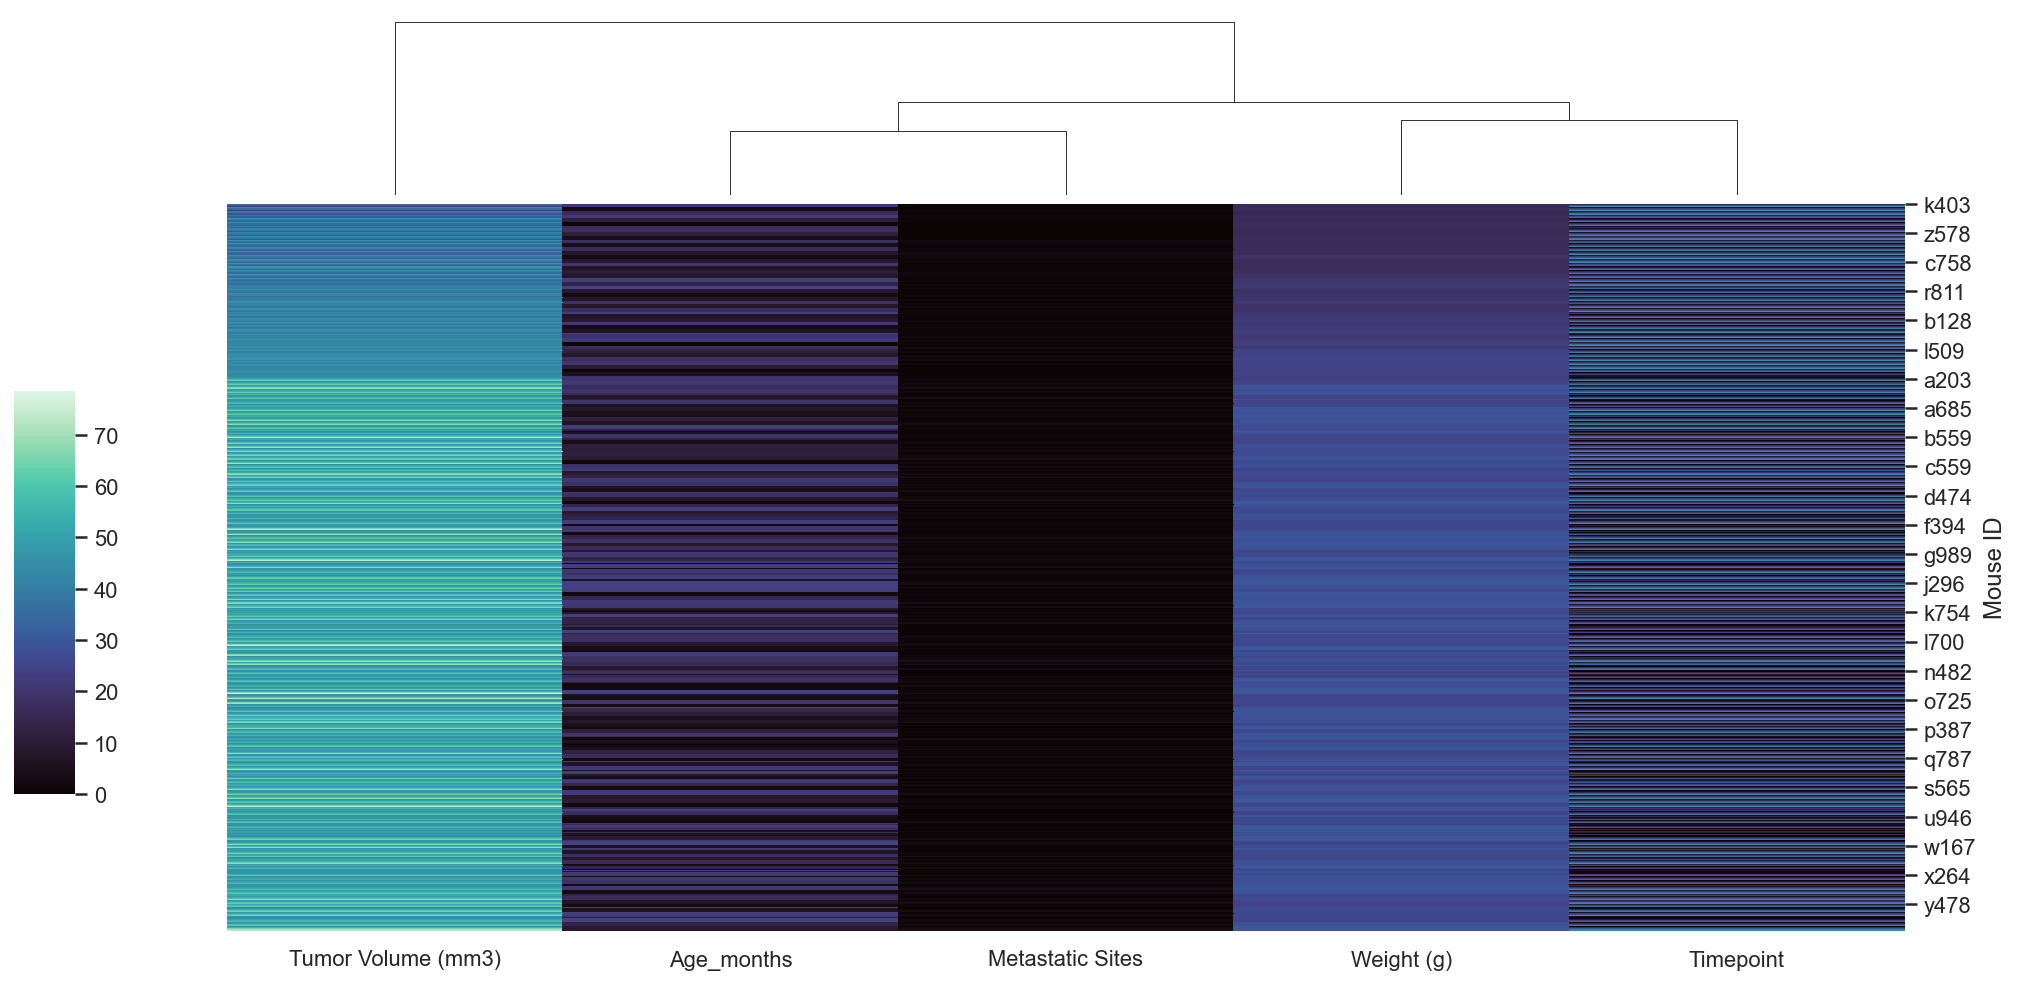

In [11]:
# Plot a hierarchically clustered heatmap
claster_data = mice_data.filter(['Age_months', 'Weight (g)', 'Timepoint', 'Tumor Volume (mm3)', 'Metastatic Sites'])
g = sns.clustermap(claster_data, cmap="mako", figsize=(14, 7), row_cluster=False,
                   dendrogram_ratio=(.1, .2), cbar_pos=(0, .2, .03, .4))

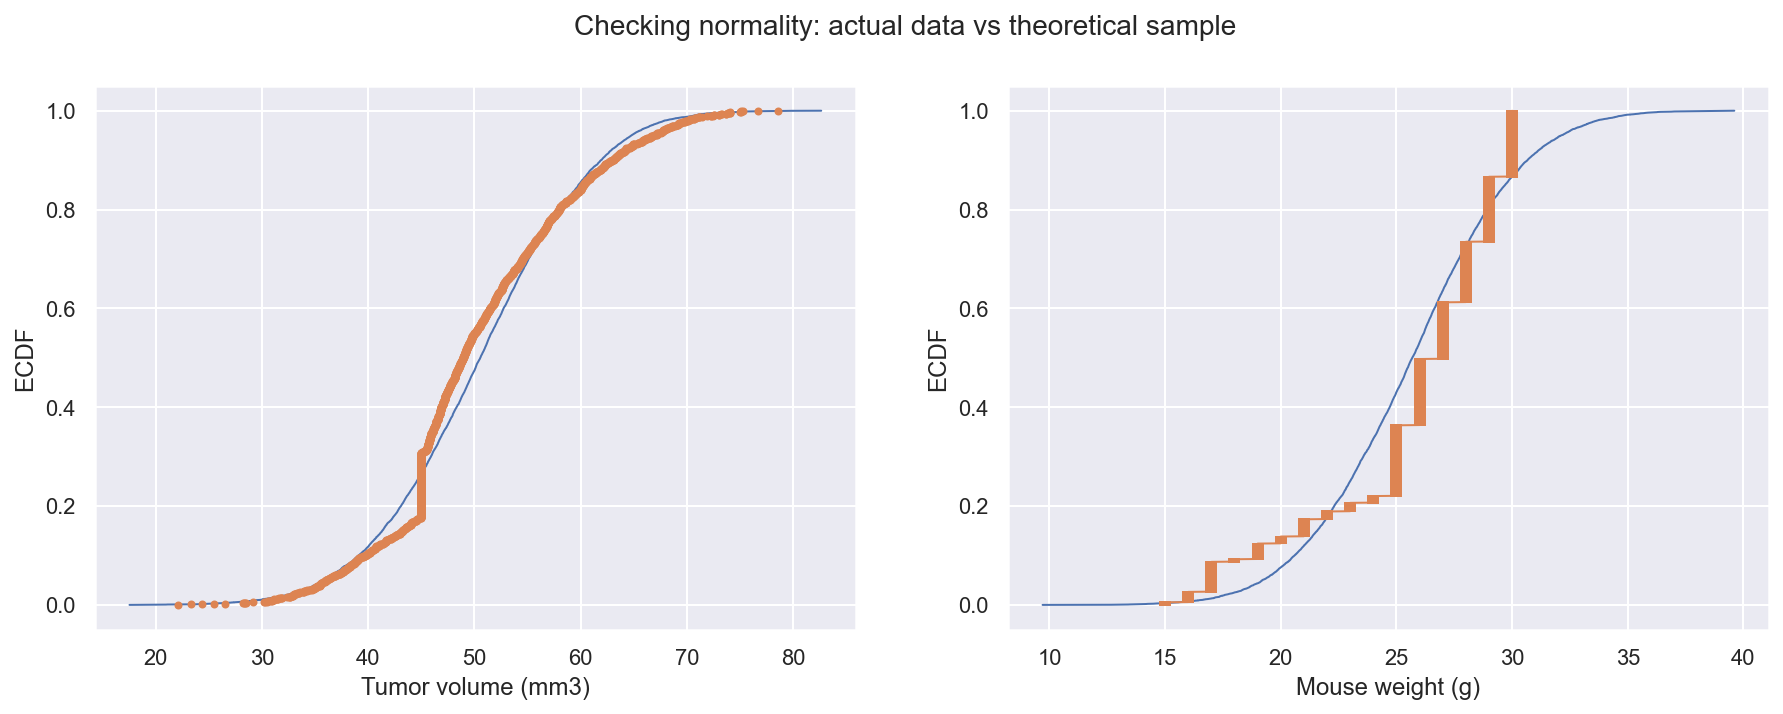

In [12]:
# Determine if the tumor volume is considered normally distributed
x_tumor, y_tumor = ecdf(tumor)
x_tumor_theor, y_tumor_theor = sample_ecdf(tumor)
# Determine if the mouse weight is considered normally distributed
x_weight, y_weight = ecdf(weight)
x_weight_theor, y_weight_theor = sample_ecdf(weight)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Checking normality: actual data vs theoretical sample', size=14)

_=ax1.plot(x_tumor_theor, y_tumor_theor)
_=ax1.plot(x_tumor, y_tumor, marker='.', linestyle='none')
_=ax1.set_xlabel('Tumor volume (mm3)')
_=ax1.set_ylabel('ECDF')

_=ax2.plot(x_weight_theor, y_weight_theor)
_=ax2.plot(x_weight, y_weight, marker = '_')
_=ax2.set_xlabel('Mouse weight (g)')
_=ax2.set_ylabel('ECDF')

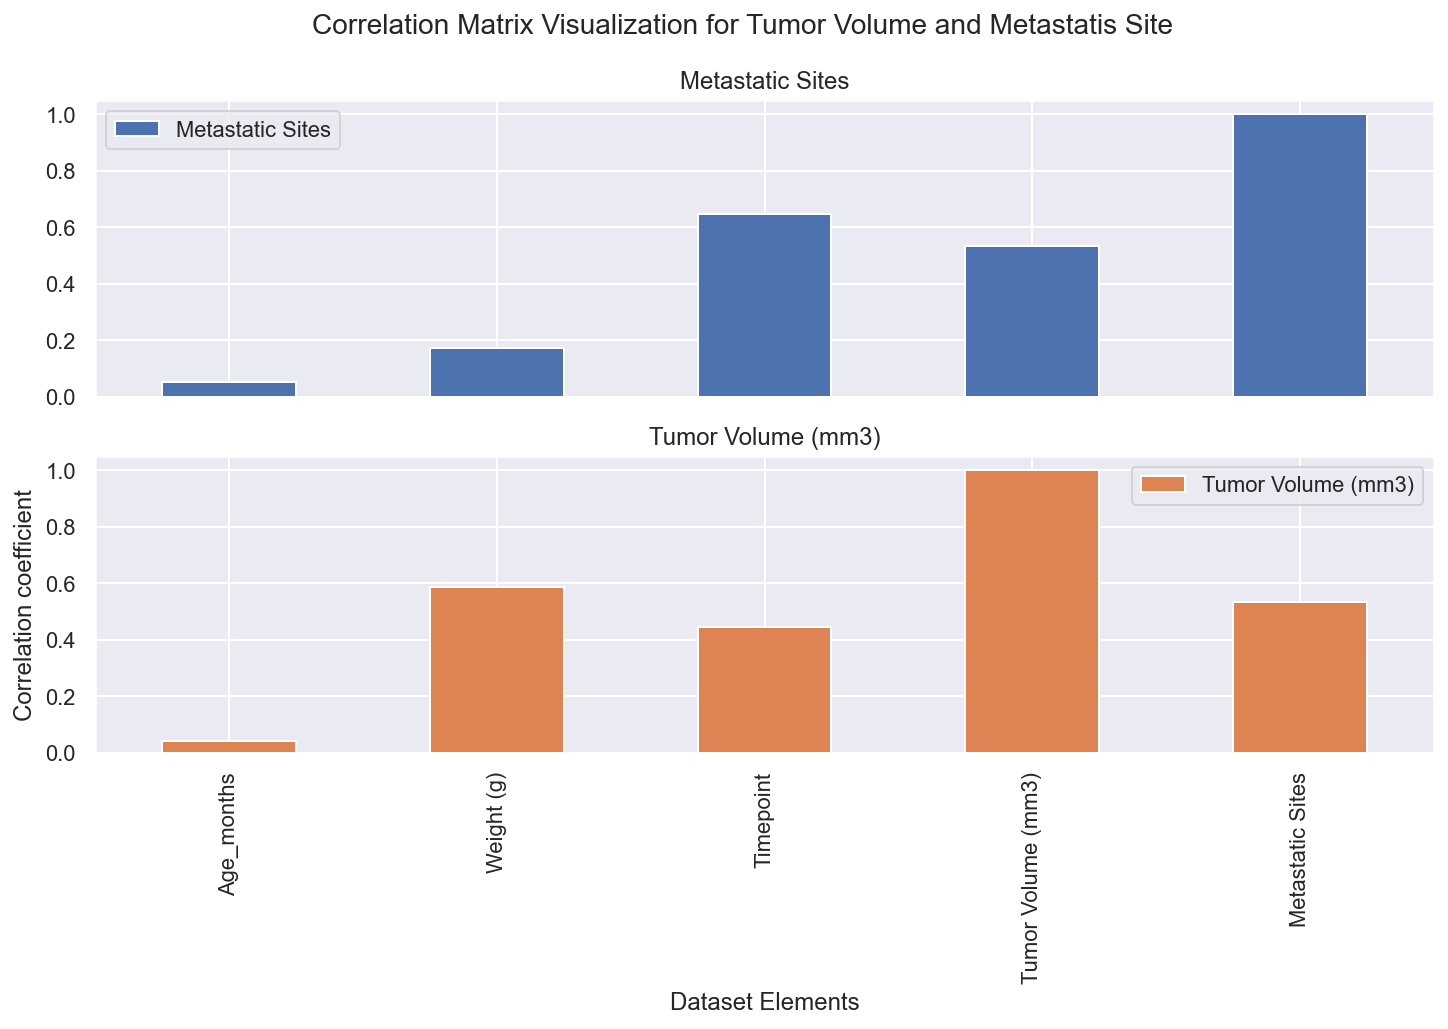

In [13]:
# Plot correlation matrix 
_=mice_data.corr()[['Metastatic Sites', 'Tumor Volume (mm3)']].plot.bar(subplots=True)
_=plt.xlabel('Dataset Elements')
_=plt.ylabel('Correlation coefficient')
_=plt.suptitle('Correlation Matrix Visualization for Tumor Volume and Metastatis Site', size=14)

In [14]:
# Generate a summary statistics table of the tumor volume for each regimen
mice_data.groupby('Drug Regimen')['Tumor Volume (mm3)'].agg(['mean', 'median','var','std','sem'])

,mean,median,var,std,sem
Drug Regimen,,,,,
Capomulin,40.68,41.56,24.95,4.99,0.33
Ceftamin,52.59,51.78,39.29,6.27,0.47
Infubinol,52.88,51.82,43.13,6.57,0.49
Ketapril,55.24,53.70,68.55,8.28,0.60
Naftisol,54.33,52.51,66.17,8.13,0.60
Placebo,54.03,52.29,61.17,7.82,0.58
Propriva,52.32,50.85,42.35,6.51,0.51
Ramicane,40.22,40.67,23.49,4.85,0.32
Stelasyn,54.23,52.43,59.45,7.71,0.57


## Bar and Pie Charts

In [15]:
# Generate a bar plot showing the total number of mice for each treatment throughout the course of the study using pandas. 
mice_per_treatment = mice_data.groupby('Drug Regimen').size()
mice_per_treatment

Drug Regimen
Capomulin    230
Ceftamin     178
Infubinol    178
Ketapril     188
Naftisol     186
Placebo      181
Propriva     161
Ramicane     228
Stelasyn     181
Zoniferol    182
dtype: int64

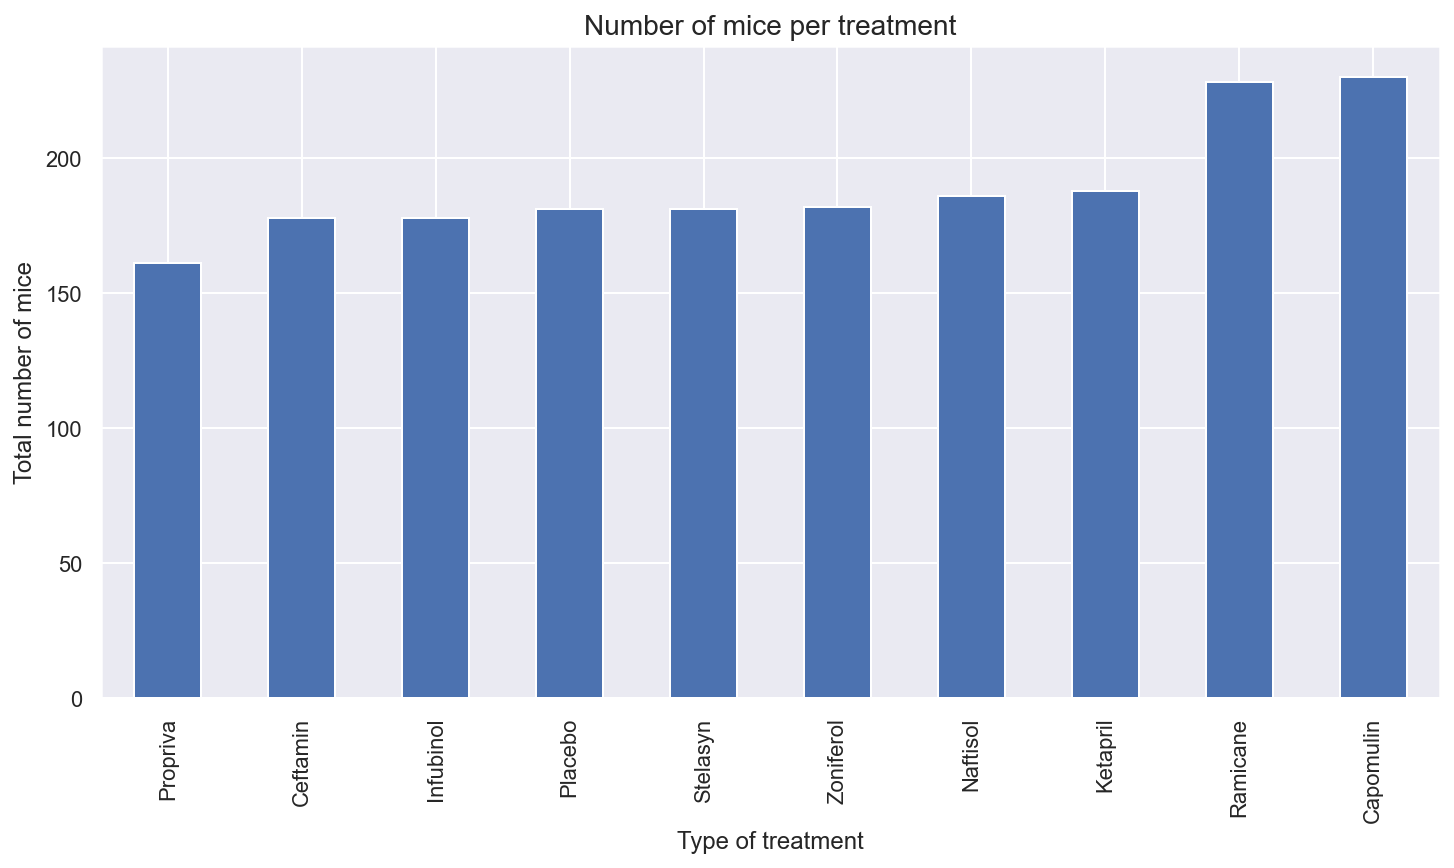

In [16]:
# Generate a bar plot showing the total number of mice for each treatment throughout the course of the study using pyplot.
_= mice_per_treatment.sort_values().plot(kind='bar')
_= plt.xlabel('Type of treatment')
_= plt.ylabel('Total number of mice')
_= plt.title('Number of mice per treatment', size=14)


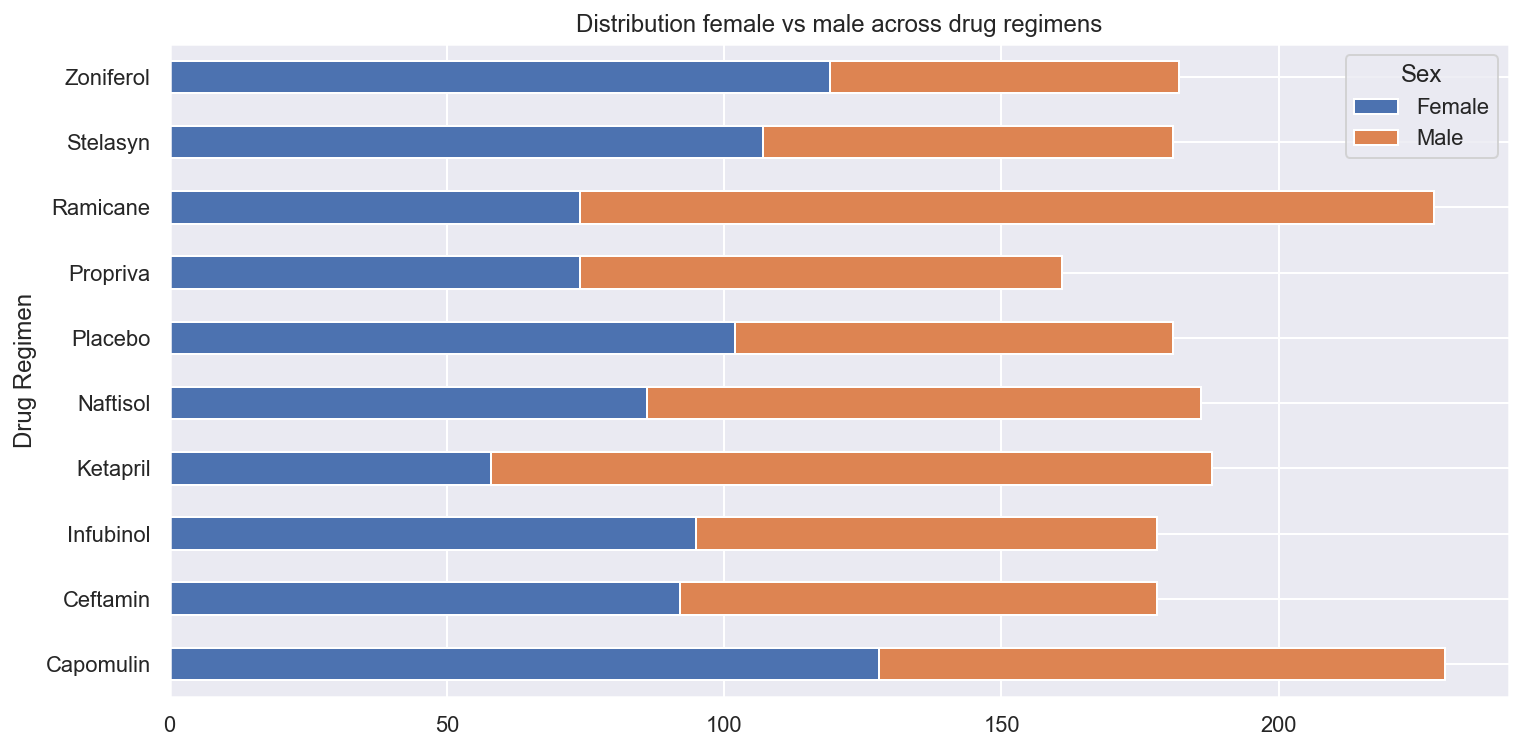

In [17]:
# Generate a pie plot showing the distribution of female versus male mice using pandas
mice_by_sex = mice_data.groupby(['Drug Regimen', 'Sex']).size()
_=mice_by_sex.unstack().plot(kind='barh', stacked=True, title="Distribution female vs male across drug regimens")

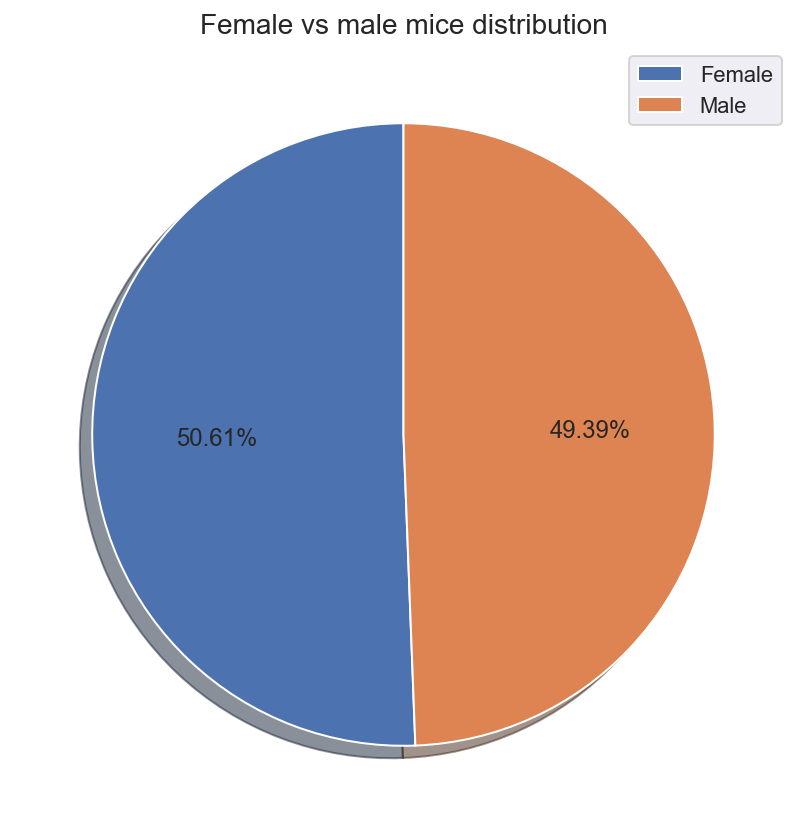

In [18]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot
_=plt.pie(mice_data['Sex'].value_counts(), autopct='%1.2f%%', shadow=True, startangle=90)
_=plt.title("Female vs male mice distribution", size=14)
_=plt.tight_layout()
_=plt.legend(['Female', 'Male'],loc="best")

## Quartiles, Outliers and Boxplots

In [19]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin
regimen_list = ['Capomulin', 'Ramicane', 'Infubinol', 'Ceftamin']
boxplot_data = mice_data[mice_data['Drug Regimen'].isin(regimen_list)]
# Get the tumor volume at the last timepoint
boxplot_df = boxplot_data.groupby(['Drug Regimen', boxplot_data.index])[['Timepoint', 'Tumor Volume (mm3)']].agg(
                                                lambda x: [x[i] for i in range(len(x)) if i == len(x)-1][0])
boxplot_df

Timepoint  Tumor Volume (mm3)
Drug Regimen Mouse ID                               
Capomulin    b128             45               38.98
             b742             45               38.94
             f966             20               30.49
             g288             45               37.07
             g316             45               40.16
...                          ...                 ...
Ramicane     s508             45               30.28
             u196             45               40.67
             w678              5               43.17
             y449             15               44.18
             z578             45               30.64

[100 rows x 2 columns]

In [20]:
# Description of output messages
MSG_1 = "\nThe lower quartile of tumor volume is: {:,.2f}"
MSG_2 = "The upper quartile of tumor volume is: {:,.2f}"
MSG_3 = "The interquartile range of tumor volume is: {:,.2f}" 
MSG_4 = "The median of tumor volume is: {:,.2f}"
MSG_5 = "Values below {:,.2f}"
MSG_6 = "could be outliers."

# Calculate the IQR and quantitatively determine if there are any potential outliers. 
quartiles = tumor.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq
lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)

print(MSG_1.format(lowerq))
print(MSG_2.format(upperq))
print(MSG_3.format(iqr))
print(MSG_4.format(quartiles[0.5]))
print(MSG_5.format(lower_bound), MSG_6)
print(MSG_5.format(upper_bound), MSG_6)


The lower quartile of tumor volume is: 45.00
The upper quartile of tumor volume is: 56.29
The interquartile range of tumor volume is: 11.29
The median of tumor volume is: 48.95
Values below 28.06 could be outliers.
Values below 73.23 could be outliers.


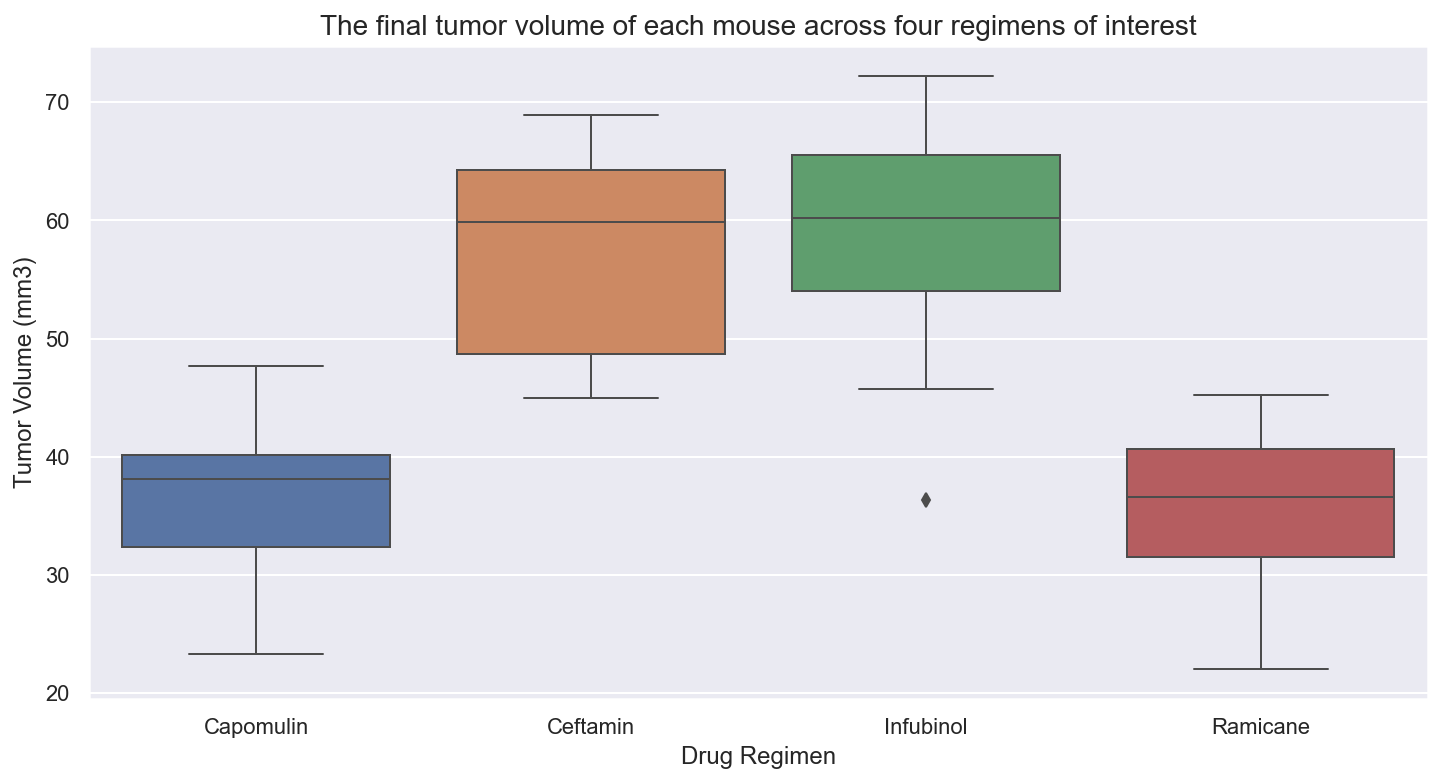

In [21]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest
_= sns.boxplot(boxplot_df.index.get_level_values(0), boxplot_df['Tumor Volume (mm3)'], data=boxplot_df)
_= plt.title('The final tumor volume of each mouse across four regimens of interest', size=14)

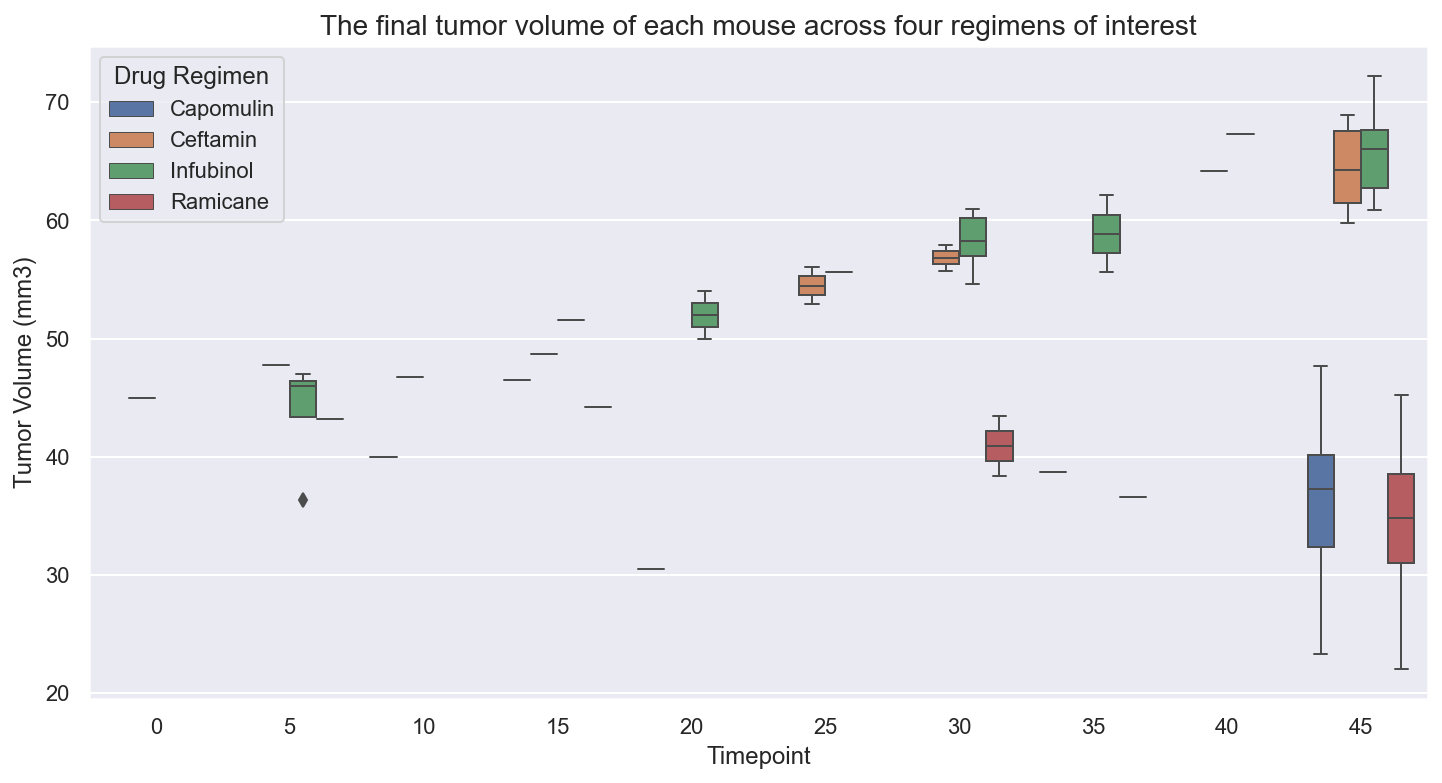

In [22]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest
_= sns.boxplot(boxplot_df['Timepoint'], boxplot_df['Tumor Volume (mm3)'], data=boxplot_df,
               hue=boxplot_df.index.get_level_values(0))
_= plt.title('The final tumor volume of each mouse across four regimens of interest', size=14)

## Line and Scatter Plots

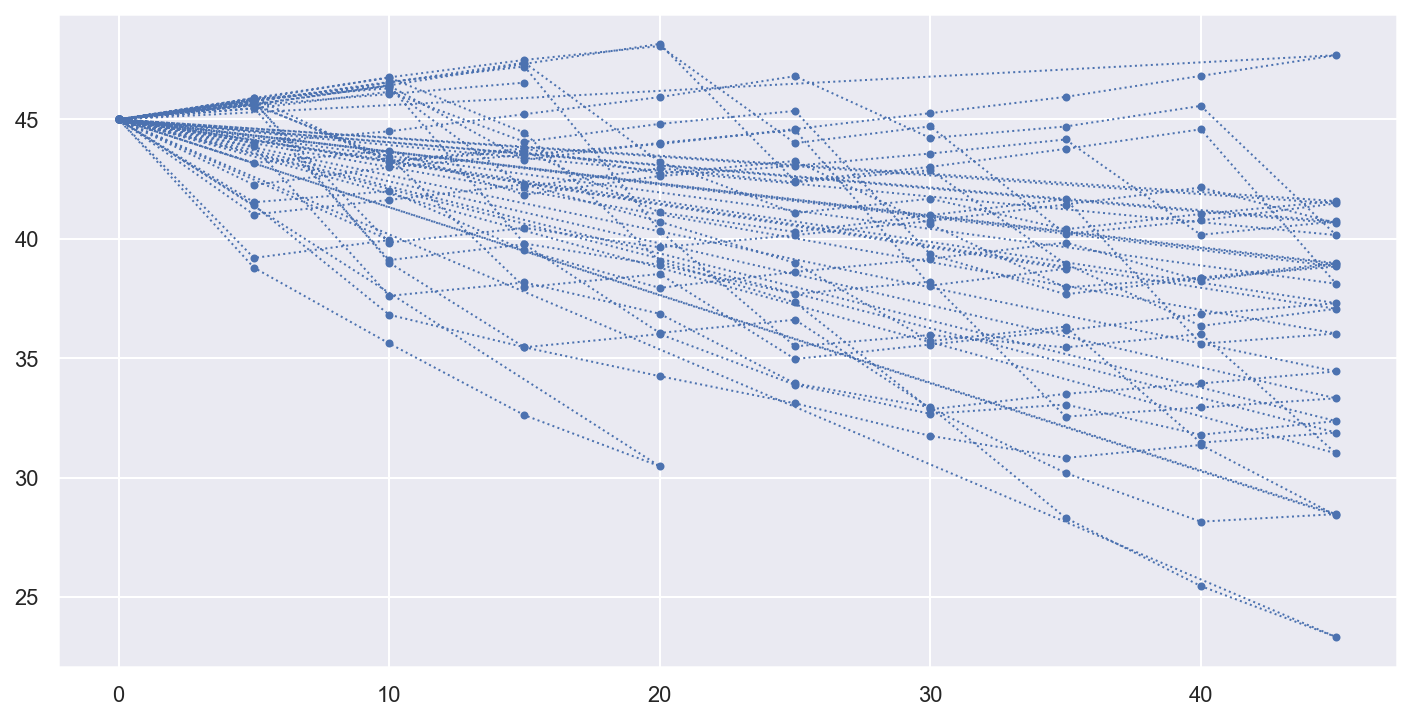

In [23]:
# Generate a line plot of time point versus tumor volume for a mouse treated with Capomulin
capomulin_df = mice_data[mice_data['Drug Regimen']=='Capomulin']
x = capomulin_df['Timepoint']
y = capomulin_df['Tumor Volume (mm3)']
_=plt.plot(x,y, marker='.', linestyle='dotted')

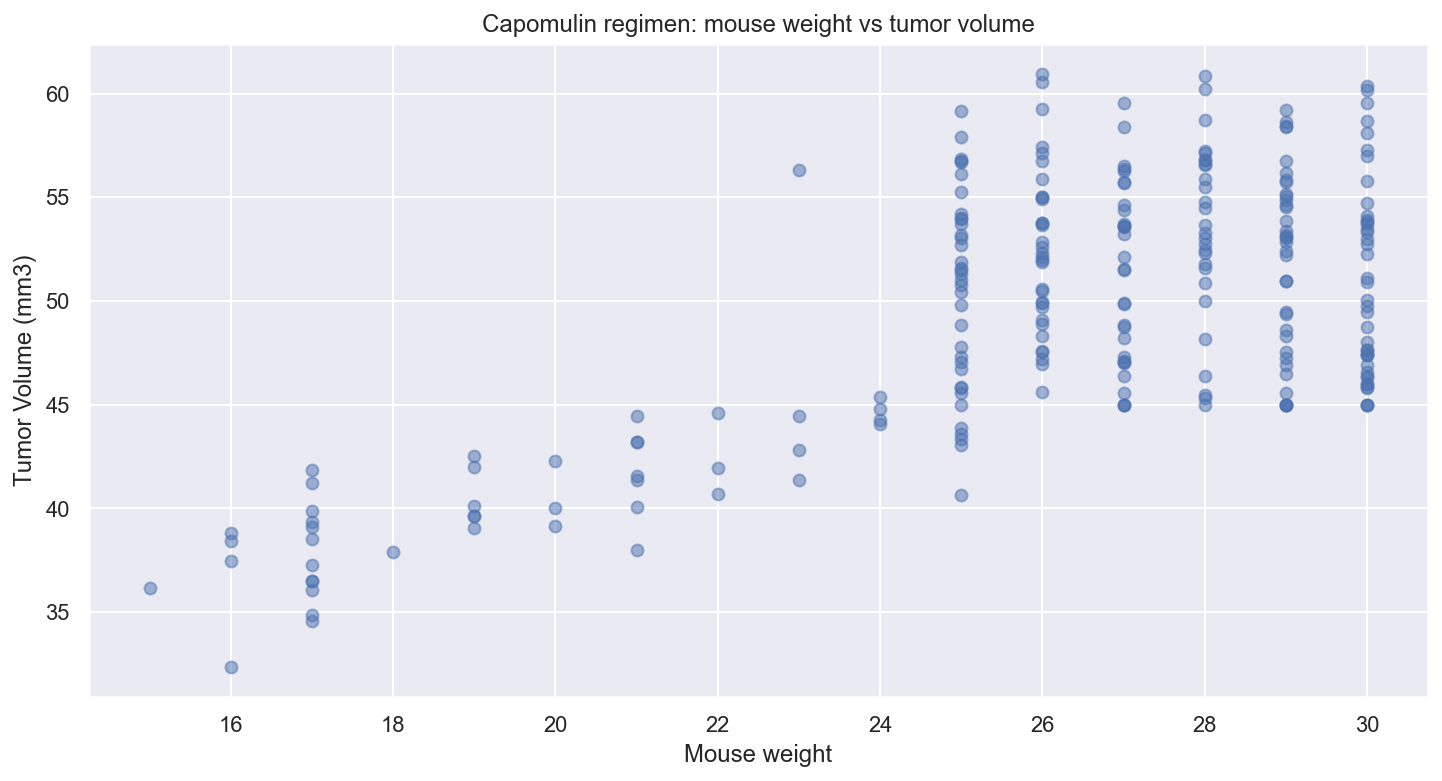

In [24]:
# Generate a scatter plot of mouse weight versus average tumor volume for the Capomulin regimen
scatter_data = mice_data.groupby(mice_data.index)[['Weight (g)', 'Tumor Volume (mm3)']].mean()
x_weight = scatter_data['Weight (g)']
y_tumor = scatter_data['Tumor Volume (mm3)']
_=plt.scatter(x_weight, y_tumor, alpha=0.5)
_=plt.xlabel('Mouse weight')
_=plt.ylabel('Tumor Volume (mm3)')
_=plt.title('Capomulin regimen: mouse weight vs tumor volume')

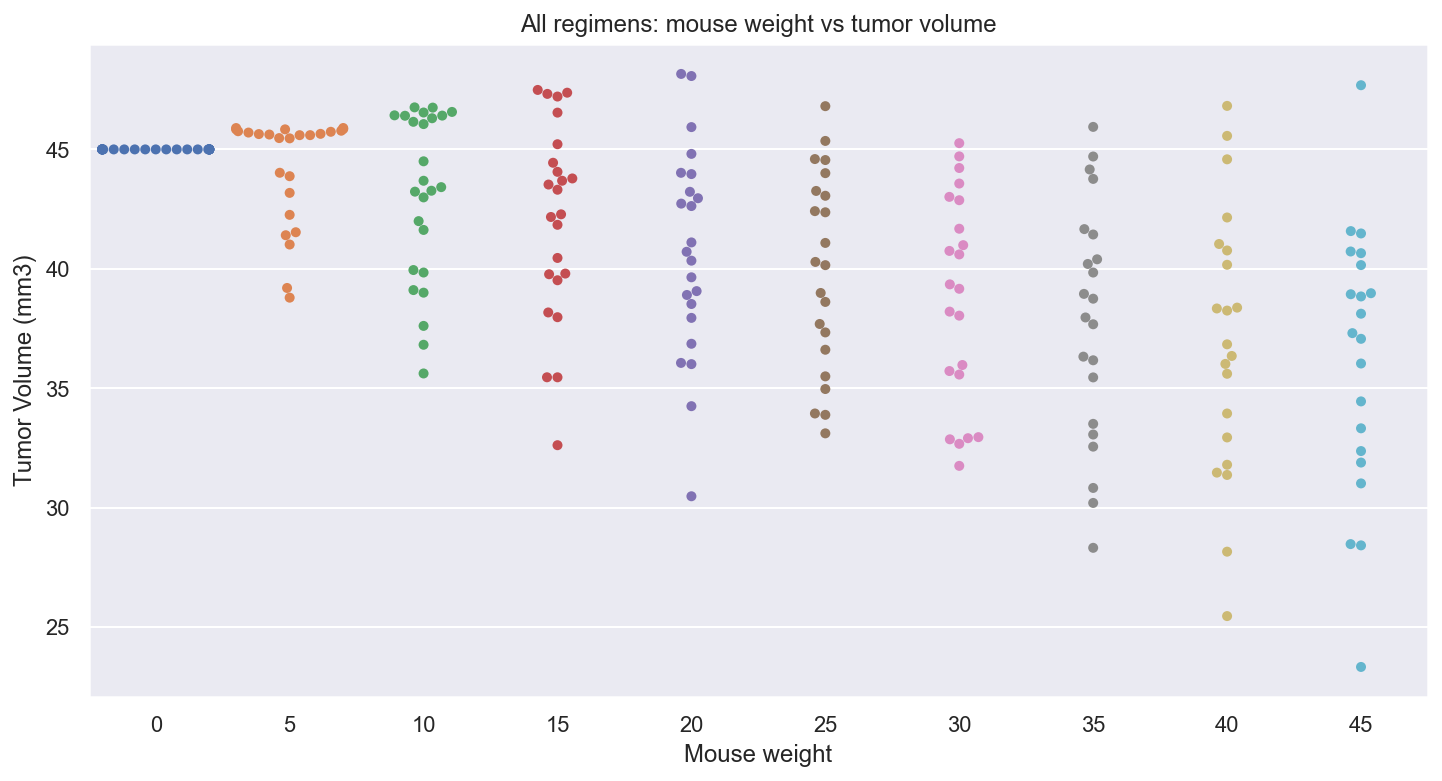

In [25]:
_=sns.swarmplot(x, y, data=scatter_data)
_=plt.xlabel('Mouse weight')
_=plt.ylabel('Tumor Volume (mm3)')
_=plt.title('All regimens: mouse weight vs tumor volume')

## Correlation and Regression

95% confidence interval for slope:
[0.95866154 1.22254157]


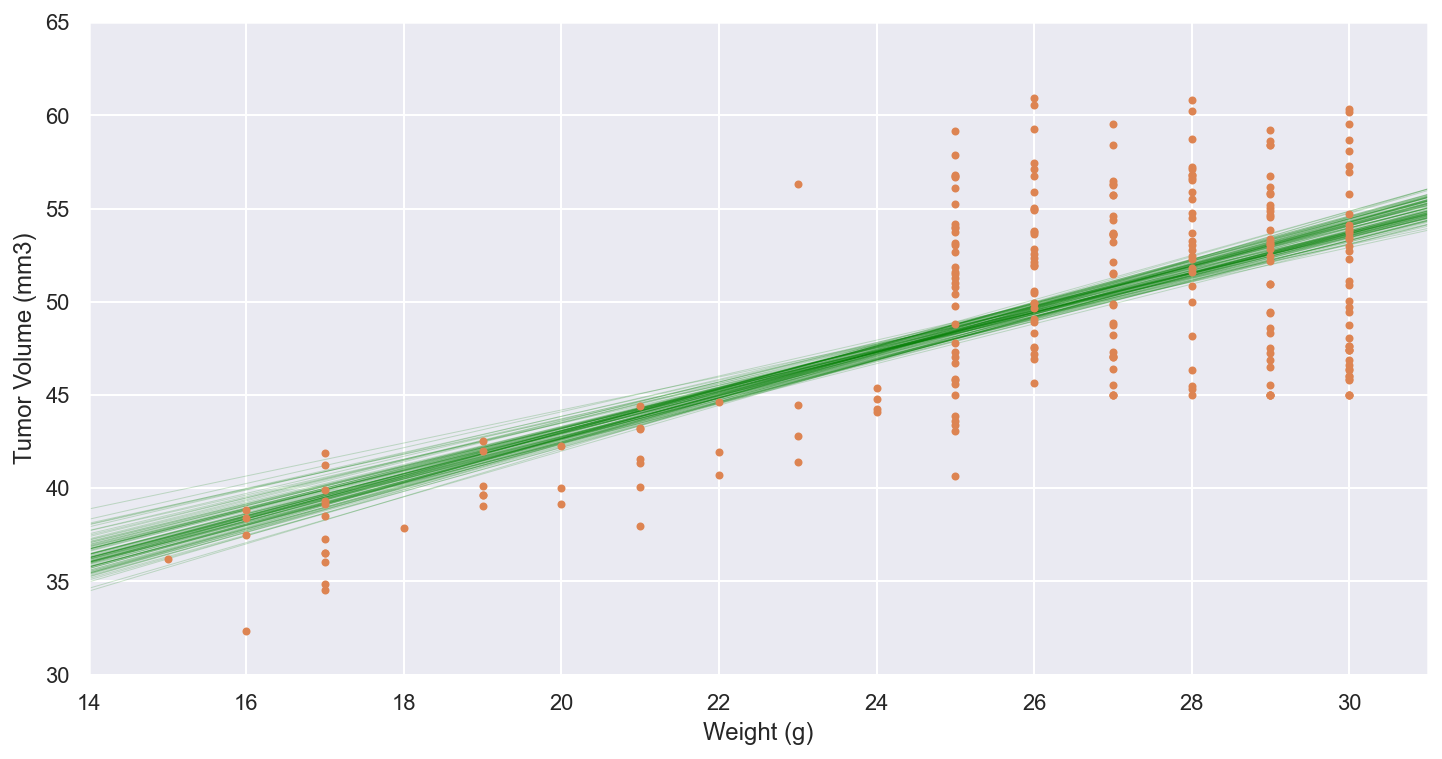

In [26]:
# Generate replicates of slope and intercept using pairs bootstrap
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(x_weight, y_tumor, 1000)

# Compute and print 95% CI for slope
print("95% confidence interval for slope:")
print(np.percentile(bs_slope_reps, [2.5,97.5]))

# Plot the histogram
_ = plt.hist(bs_slope_reps, bins=50)
_ = plt.xlabel('slope')
_ = plt.ylabel('PDF')

# Generate array of x-values for bootstrap lines: x
x = np.array([0,100])

# Plot the bootstrap lines
for i in range(100):
    _ = plt.plot(x, 
                 bs_slope_reps[i]*x + bs_intercept_reps[i],
                 linewidth=0.5, alpha=0.2, color ='green')

# Plot the data
_ = plt.plot(x_weight, y_tumor, marker='.', linestyle='none')

# Label axes, set the margins, and show the plot
_ = plt.xlabel('Weight (g)')
_ = plt.ylabel('Tumor Volume (mm3)')
_ = plt.ylim(30,65)
_ = plt.xlim(14,31)
plt.margins(0.02)
